# Plotting Energy Density Transform

In [1]:
from data import DEData
import torch
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
dataset = DEData('dE_data') + DEData('dE_data_2')

data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    shuffle=True
)

In [3]:
model = torch.load('dE_model.pt')
model.eval()

DEModel(
  (linear): Linear(in_features=64, out_features=141, bias=False)
)

In [4]:
graph_1_sums = []
graph_2_sums = []

for i, data in enumerate(data_loader):
    dE_initial = data[0]
    dNch_deta_final = data[1]
    x_axis = dataset.data_axis

    outputs = model(dE_initial.float())

    indices = []
    sum_x_axis = []

    for i, eta in enumerate(x_axis):
        if -4.9 < x_axis[i] < -4:
            indices.append(i)
            sum_x_axis.append(eta)

    for i, p in enumerate(dNch_deta_final):
        graph_1_sums.append( ( np.trapz(dE_initial[i][indices[0] : indices[-1] + 1], x=sum_x_axis), np.trapz(p[indices[0] : indices[-1] + 1], x=sum_x_axis) )  )

        graph_2_sums.append( ( np.trapz(outputs.detach().numpy()[i][indices[0] : indices[-1] + 1], x=sum_x_axis), np.trapz(p[indices[0] : indices[-1] + 1], x=sum_x_axis) )  )

graph_1_sums = np.array(graph_1_sums).transpose()
graph_2_sums = np.array(graph_2_sums).transpose()

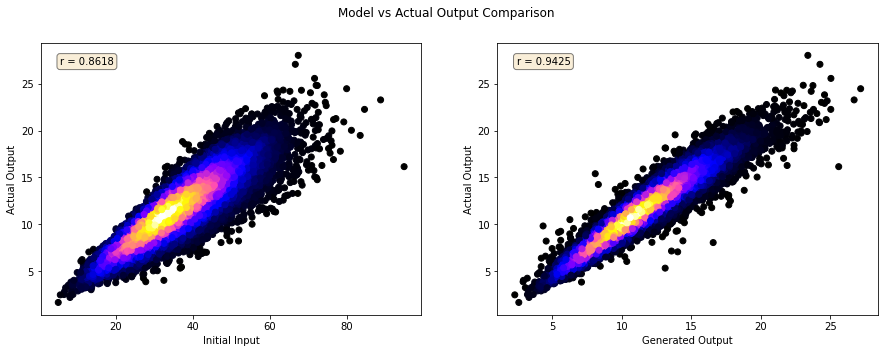

In [5]:
gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(15, 5))
fig.suptitle("Model vs Actual Output Comparison")

ax0 = fig.add_subplot(gs[0, 0])

z1 = stats.gaussian_kde(graph_1_sums)(graph_1_sums)

color_map = 'gnuplot2'

ax0.scatter(graph_1_sums[0], graph_1_sums[1], c=z1, cmap=color_map)

ax0.set_xlabel('Initial Input')
ax0.set_ylabel('Actual Output')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax0.text(0.05, 0.95, f'r = {stats.pearsonr(graph_1_sums[0], graph_1_sums[1])[0]:.4f}', verticalalignment='top', bbox=props, transform=ax0.transAxes)

ax1 = fig.add_subplot(gs[0, 1])

z2 = stats.gaussian_kde(graph_2_sums)(graph_2_sums)

ax1.text(0.05, 0.95, f'r = {stats.pearsonr(graph_2_sums[0], graph_2_sums[1])[0]:.4f}', verticalalignment='top', bbox=props, transform=ax1.transAxes)

ax1.scatter(graph_2_sums[0], graph_2_sums[1], c=z2, cmap=color_map )

ax1.set_xlabel('Generated Output')
ax1.set_ylabel('Actual Output')

plt.show()